In [19]:
#Import essential libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay
)
from wordcloud import WordCloud

In [3]:
import chardet
with open("/content/spam.csv", 'rb') as x:
  result = chardet.detect(x.read())
  print(result['encoding'])

Windows-1252


error is "utf-8' codec can't decode bytes in position 606-607: invalid continuation byte", therefore, we'll use "chardet" library

In [5]:
data = pd.read_csv("/content/spam.csv", encoding = 'Windows-1252')
data_copy = data.copy()

data.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [6]:
#Remove unnecesarry columns
data.drop(columns = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace = True, axis =1)
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
#Rename columns
data = data.rename(columns = {"v1": "label", "v2": "text"})
data.columns

Index(['label', 'text'], dtype='object')

In [15]:
data = data.drop_duplicates()

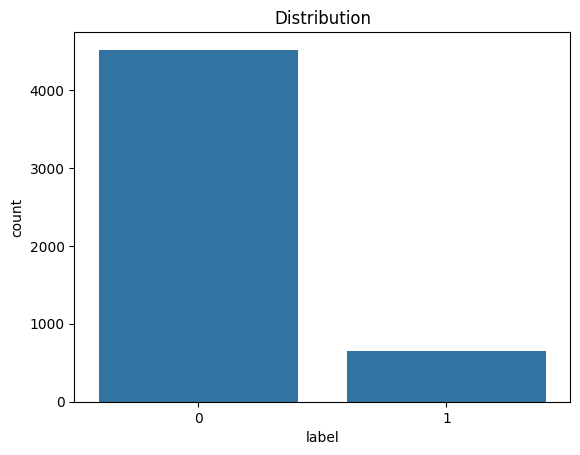

label
0    4516
1     653
Name: count, dtype: int64


In [22]:
sns.countplot(data=data, x='label')
plt.title("Distribution")
plt.show()

print(data['label'].value_counts())

In [17]:
#Encoding: ham = 0, and spam = 1
data['label'] = data['label'].map({'ham': 0, 'spam': 1})
data['label'].unique()

array([0, 1])

In [18]:
#Null values
data.isnull().sum()

,0
label,0
text,0


In [23]:
#Text preprocessing
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [25]:
def clean_text(sentence):
  sentence = sentence.lower()
  loc = re.compile("[^a-zA-Z]")
  sentence = re.sub(loc, " ", sentence)
  ps = PorterStemmer()
  w = [word for word in sentence.split() if word not in stopwords.words('english')]
  w = [ps.stem(word) for word in w]
  return ''.join(w)

data['clean_text'] = data['text'].apply(clean_text)

In [26]:
data.head(10)

,label,text,clean_text
0,0,"Go until jurong point, crazy.. Available only ...",gojurongpointcraziavailbugingreatworldlaebuffe...
1,0,Ok lar... Joking wif u oni...,oklarjokewifuoni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,freeentriwklicompwinfacupfinaltktstmaytextfare...
3,0,U dun say so early hor... U c already then say...,udunsayearlihorucalreadisay
4,0,"Nah I don't think he goes to usf, he lives aro...",nahthinkgoeusflivearoundthough
5,1,FreeMsg Hey there darling it's been 3 week's n...,freemsgheydarlweekwordbacklikefunstilltbokxxxs...
6,0,Even my brother is not like to speak with me. ...,evenbrotherlikespeaktreatlikeaidpatent
7,0,As per your request 'Melle Melle (Oru Minnamin...,perrequestmellmelloruminnaminungintnurunguvett...
8,1,WINNER!! As a valued network customer you have...,winnervalunetworkcustomselectreceiveaprizerewa...
9,1,Had your mobile 11 months or more? U R entitle...,mobilmonthurentitlupdatlatestcolourmobilcamera...


In [55]:
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(data['clean_text'])
y = data['label']

In [56]:
#spliting data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [57]:
#Model
model = MultinomialNB()
model.fit(x_train, y_train)
pred = model.predict(x_test)

In [58]:
#Metrics
acs = accuracy_score(y_test, pred)
print(f"Accuracy score: {round((acs * 100), 2)}")

Accuracy score: 86.17


In [64]:
#Hyperparameter tuning

params = {'alpha': [0.1, 0.5, 1]}
grid = GridSearchCV(model, param_grid = params, cv = 10, scoring = 'accuracy')
grid.fit(x_train, y_train)

print("Best parameters: ", grid.best_params_)

Best parameters:  {'alpha': 0.1}


In [63]:
#Model after tuning

model = MultinomialNB(alpha = 0.1)
model.fit(x_train, y_train)
pred = model.predict(x_test)

Accuracy score: 88.2
Classification report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.94       889
           1       1.00      0.16      0.27       145

    accuracy                           0.88      1034
   macro avg       0.94      0.58      0.60      1034
weighted avg       0.90      0.88      0.84      1034



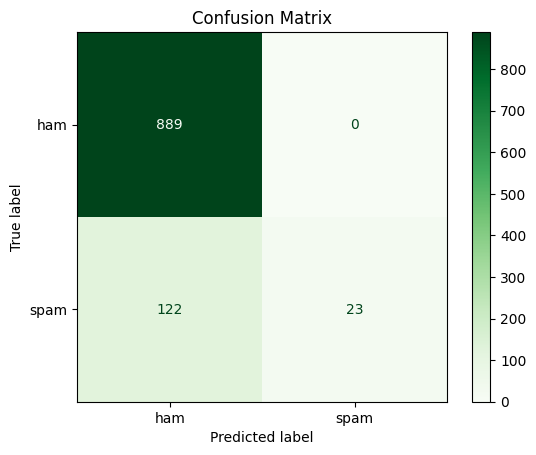

In [65]:
#Metrics after tuning

acs = accuracy_score(y_test, pred)
print(f"Accuracy score: {round((acs * 100), 2)}")

cr = classification_report(y_test, pred)
print("Classification report: \n", cr)

# cm = confusion_matrix(y_test, pred)
# sns.heatmap(cm, annot = True, cmap = 'Greens', fmt = 'd')
# plt.title("Confusion Matrix")
# plt.show()

cm = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, pred), \
                            display_labels = ['ham', 'spam'])
cm.plot(cmap = 'Greens')
plt.title("Confusion Matrix")
plt.show()

AUC score:  0.5859353787673093


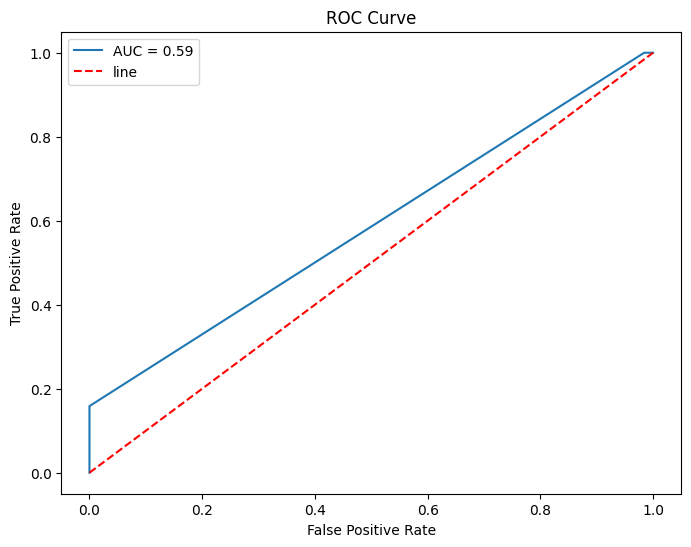

In [66]:
#Roc curve

y_proba = model.predict_proba(x_test)[:, 1]

auc = roc_auc_score(y_test, y_proba)
print("AUC score: ", auc)

fpr, tpr, threshold = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'red', label="line")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

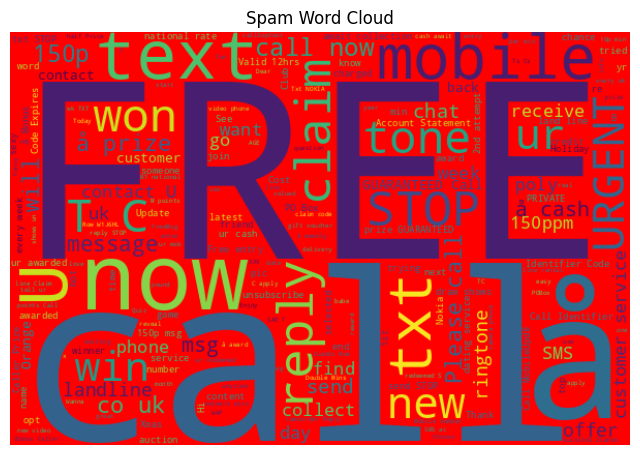

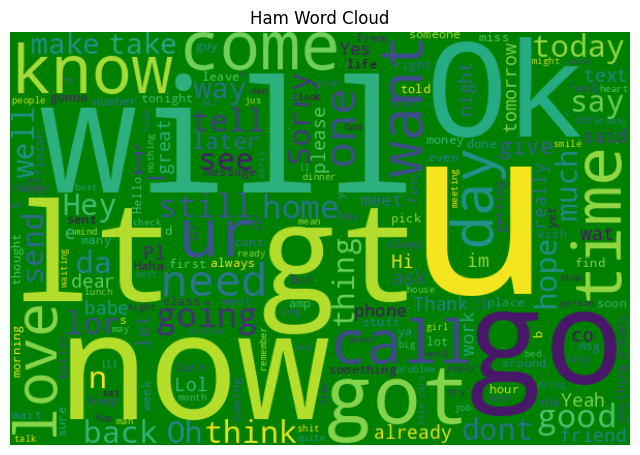

In [34]:
#Funny :D

spam_words = " ".join(data[data['label'] == 1]['text'])
ham_words = " ".join(data[data['label'] == 0]['text'])

# Spam word cloud
spam_cloud = WordCloud(width=600, height=400, background_color='red').generate(spam_words)
plt.figure(figsize=(8, 6))
plt.imshow(spam_cloud, interpolation="bilinear")
plt.title("Spam Word Cloud")
plt.axis("off")
plt.show()

# Ham word cloud
ham_cloud = WordCloud(width=600, height=400, background_color='green').generate(ham_words)
plt.figure(figsize=(8, 6))
plt.imshow(ham_cloud, interpolation="bilinear")
plt.title("Ham Word Cloud")
plt.axis("off")
plt.show()